In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from __future__ import print_function

/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
#hyper-parameters
batch_size = 128
num_epochs = 100
learning_rate = 1e-3
seed = 1

In [4]:
torch.manual_seed(seed)

In [5]:
root = "../data/"
train_dataset = datasets.MNIST(root,
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root,
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=64,
                                              shuffle=False)

In [6]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler, Prob, Expectation as E
from pixyz.models import Model
from pixyz.utils import print_latex

In [50]:
x_dim = 28*28
z_dim = 20

# q(z|x)
class Inference1(Normal):
    def __init__(self, x_dim, z_dim):
        super(Inference1, self).__init__(var=["z_1"], cond_var=["x"], name="q")
        
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(5*5*32, 256)
        self.fc2_1 = nn.Linear(256, z_dim)
        self.fc2_2 = nn.Linear(256, z_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        return {"loc": self.fc2_1(x), "scale": F.softplus(self.fc2_2(x))}

class Inference2(Normal):
    def __init__(self, x_dim, z_dim):
        super(Inference2, self).__init__(var=["z_2"], cond_var=["x"], name="q")
        
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(5*5*32, 256)
        self.fc2_1 = nn.Linear(256, z_dim)
        self.fc2_2 = nn.Linear(256, z_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        return {"loc": self.fc2_1(x), "scale": F.softplus(self.fc2_2(x))}

class Inference(Normal):
    def __init__(self, x_dim, z1_dim, z2_dim):
        super(Inference, self).__init__(var=["z_1", "z_2"], cond_var=["x"], name="q")
        
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(5*5*32, 256)
        self.fc2_1 = nn.Linear(256, z1_dim + z2_dim)
        self.fc2_2 = nn.Linear(256, z1_dim + z2_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        return {"loc": self.fc2_1(x), "scale": F.softplus(self.fc2_2(x))}

#p(x|z)
class Generator1(Bernoulli):
    def __init__(self, x_dim, z1_dim, z2_dim):
        super(Generator1, self).__init__(var=["x"], cond_var=["z_1", "z_2"], name="p")
        
        self.fc1 = nn.Linear(z1_dim + z2_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)
    
    def forward(self, z_1, z_2):
        z = torch.concat([z_1, z_2], dim=1)
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h)).view(-1, 1, 28, 28)}


p1 = Generator1(x_dim, z_dim, z_dim).to(device)
q1 = Inference1(x_dim, z_dim).to(device)
q2 = Inference2(x_dim, z_dim).to(device)
q = Inference(x_dim, z_dim, z_dim).to(device)

prior = Normal(var=["z"],
               loc=torch.tensor(0.),
               scale=torch.tensor(1.),
               features_shape=[z_dim],
               name="p_{prior}").to(device)

In [51]:
print(prior)
print_latex(prior)

Distribution:
  p_{prior}(z)
Network architecture:
  Normal(
    name=p_{prior}, distribution_name=Normal,
    var=['z'], cond_var=[], input_var=[], features_shape=torch.Size([20])
    (loc): torch.Size([1, 20])
    (scale): torch.Size([1, 20])
  )


<IPython.core.display.Math object>

In [52]:
print(p1)
print_latex(p1)

Distribution:
  p(x|z_{1},z_{2})
Network architecture:
  Generator1(
    name=p, distribution_name=Bernoulli,
    var=['x'], cond_var=['z_1', 'z_2'], input_var=['z_1', 'z_2'], features_shape=torch.Size([])
    (fc1): Linear(in_features=40, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )


<IPython.core.display.Math object>

In [53]:
print(q1 * q2)
print_latex(q1 * q2)

Distribution:
  q(z_{1},z_{2}|x) = q(z_{2}|x)q(z_{1}|x)
Network architecture:
  q(z_{1}|x):
  Inference1(
    name=q, distribution_name=Normal,
    var=['z_1'], cond_var=['x'], input_var=['x'], features_shape=torch.Size([])
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=800, out_features=256, bias=True)
    (fc2_1): Linear(in_features=256, out_features=20, bias=True)
    (fc2_2): Linear(in_features=256, out_features=20, bias=True)
  )
  q(z_{2}|x):
  Inference2(
    name=q, distribution_name=Normal,
    var=['z_2'], cond_var=['x'], input_var=['x'], features_shape=torch.Size([])
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1

<IPython.core.display.Math object>

In [54]:
print(q)
print_latex(q)

Distribution:
  q(z_{1},z_{2}|x)
Network architecture:
  Inference(
    name=q, distribution_name=Normal,
    var=['z_1', 'z_2'], cond_var=['x'], input_var=['x'], features_shape=torch.Size([])
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=800, out_features=256, bias=True)
    (fc2_1): Linear(in_features=256, out_features=40, bias=True)
    (fc2_2): Linear(in_features=256, out_features=40, bias=True)
  )


<IPython.core.display.Math object>

In [55]:
kl1 = KullbackLeibler(q1, prior)
kl2 = KullbackLeibler(q2, prior)
reconst = -p1.log_prob().expectation(q1*q2)
independ = KullbackLeibler(q1 * q2, q)
loss = (reconst+kl1+kl2).mean()
print_latex(loss)

<IPython.core.display.Math object>

In [56]:
model = Model(loss=loss,
              distributions=[p1, q1, q2],
              optimizer=torch.optim.AdamW,
              optimizer_params={"lr": learning_rate})
print(model)
print_latex(model)

Distributions (for training):
  p(x|z_{1},z_{2}), q(z_{1}|x), q(z_{2}|x)
Loss function:
  mean \left(D_{KL} \left[q(z_{1}|x)||p_{prior}(z) \right] + D_{KL} \left[q(z_{2}|x)||p_{prior}(z) \right] - \mathbb{E}_{q(z_{1},z_{2}|x)} \left[\log p(x|z_{1},z_{2}) \right] \right)
Optimizer:
  AdamW (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      eps: 1e-08
      foreach: None
      lr: 0.001
      maximize: False
      weight_decay: 0.01
  )


<IPython.core.display.Math object>

In [57]:
def train(epoch):
    train_loss = 0
    for x, _ in train_dataloader:
        x = x.to(device)
        loss = model.train({"x": x})
        train_loss += loss
    
    train_loss = train_loss * train_dataloader.batch_size / len(train_dataloader.dataset)
    print("Epoch[{}/{}], Train Loss: {:.4f}".format(epoch, num_epochs, train_loss))
    return train_loss

losses = []
for epoch in range(1, num_epochs + 1):
    losses.append(train(epoch))

Epoch[1/100], Train Loss: 182.8798
Epoch[2/100], Train Loss: 129.2153
Epoch[3/100], Train Loss: 117.1421
Epoch[4/100], Train Loss: 112.2833
Epoch[5/100], Train Loss: 109.1967
Epoch[6/100], Train Loss: 107.1637
Epoch[7/100], Train Loss: 105.8001
Epoch[8/100], Train Loss: 104.7892
Epoch[9/100], Train Loss: 103.9150
Epoch[10/100], Train Loss: 103.2561
Epoch[11/100], Train Loss: 102.6771
Epoch[12/100], Train Loss: 102.1358
Epoch[13/100], Train Loss: 101.7174
Epoch[14/100], Train Loss: 101.2795
Epoch[15/100], Train Loss: 100.9550
Epoch[16/100], Train Loss: 100.6604
Epoch[17/100], Train Loss: 100.3758
Epoch[18/100], Train Loss: 100.0990
Epoch[19/100], Train Loss: 99.8697
Epoch[20/100], Train Loss: 99.6514
Epoch[21/100], Train Loss: 99.4879
Epoch[22/100], Train Loss: 99.3391
Epoch[23/100], Train Loss: 99.0901
Epoch[24/100], Train Loss: 99.0506
Epoch[25/100], Train Loss: 98.7482
Epoch[26/100], Train Loss: 98.6896
Epoch[27/100], Train Loss: 98.5231
Epoch[28/100], Train Loss: 98.4141
Epoch[29/10

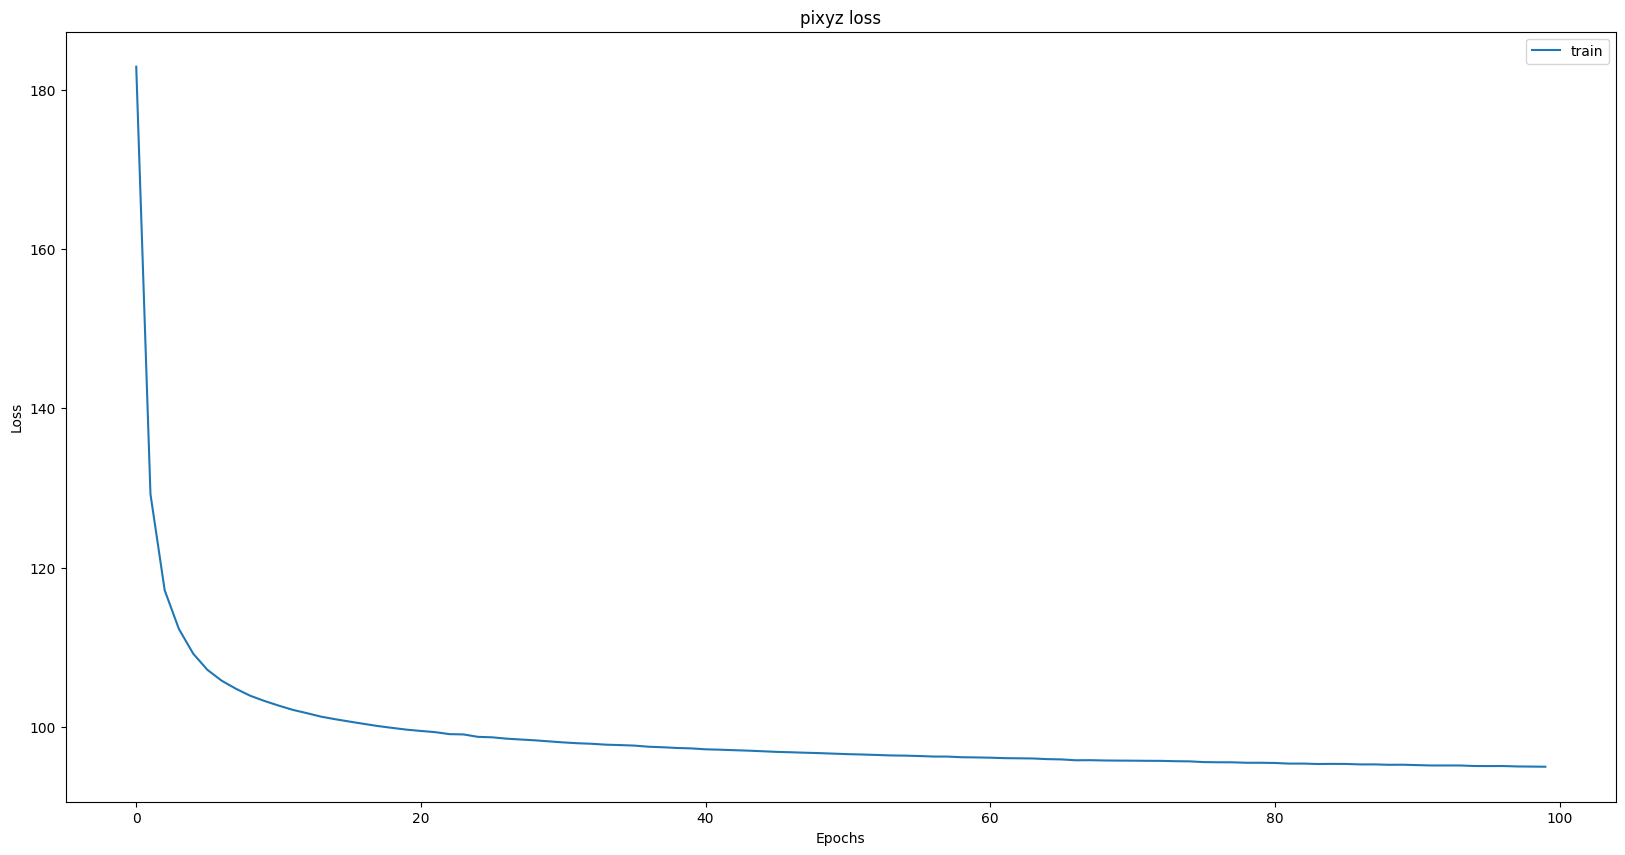

In [58]:
import matplotlib.pyplot as plt

losses = [x.tolist() for x in losses]

x = list(range(len(losses)))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

ax.set_title("pixyz loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.plot(x, losses, label="train")
ax.legend()

plt.show()

In [59]:
import matplotlib.pyplot as plt

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [60]:
#reconstruction

z_list = []
y_list = []

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.to(device)
        z = q.sample({"x": x}, return_all=False)
        z_list.append(z["z"])
        y_list.append(y)
    
    recon_batch = p.sample_mean(z).view(-1,1,28,28)
    comparison = torch.cat([x.view(-1,1,28,28), recon_batch], dim=3).cpu()
    imshow(torchvision.utils.make_grid(comparison))

KeyError: 'z'

In [ ]:
z_list = torch.cat(z_list).cpu().numpy()
y_list = torch.cat(y_list).cpu().numpy()
print(z_list.shape)
print(y_list.shape)

(10000, 20)
(10000,)


/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


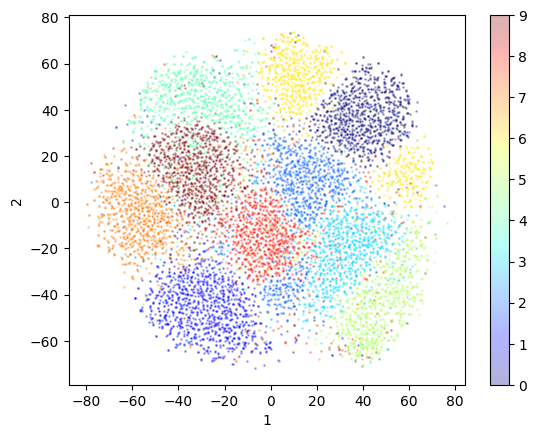

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
z_list = tsne.fit_transform(z_list)

import matplotlib.colors as colors

fig = plt.figure()
ax = fig.add_subplot()

ax.set_xlabel("1")
ax.set_ylabel("2")

for x, y in zip(z_list, y_list):
    mp = ax.scatter(x[0], x[1],
                    alpha=0.3,
                    c=y,
                    s=0.8,
                    vmin=0,
                    vmax=9,
                    cmap="jet")

fig.colorbar(mp, ax=ax)

plt.show()

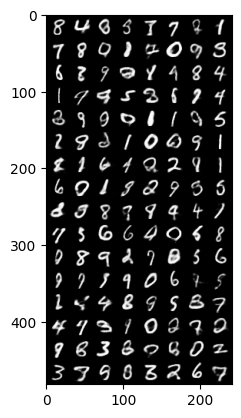

In [ ]:
#sampling

z_samples = torch.randn(batch_size, z_dim).to(device)
with torch.no_grad():
    sample = p.sample_mean({"z": z_samples}).view(-1,1,28,28).cpu()
    imshow(torchvision.utils.make_grid(sample))